<a href="https://colab.research.google.com/github/JDslay/LKA/blob/main/DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning of pretrained AlexNet (on ImageNet-Dataset) with Tobacco3482-Dataset 
Initially the AlexNet was trained with the purpose of classifying images into 1000 categories like cat and dog.
This notebook retraines the last fully connected layer of AlexNet on images of documents to categorize 10 classes (ADVE, Email, Form, Letter, Memo, News, Note, Report, Resume, Scientific)

In the import section the file for plotting the confusion matrix is imported from my Github-Repository.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import httpimport
url = "https://raw.githubusercontent.com/JDslay/LKA/main/resources"     # from deeplizard.com respectively scikit-learn.org
with httpimport.remote_repo(["plotcm"], url):
    import plotcm                                        
import time
import progressbar

For testing purposes, data of my Google Drive have been mounted

In [1]:
from google.colab import drive
drive.mount('/content/drive')  

Mounted at /content/drive


Later used functions for the evaluation of the model have to be initialized

In [3]:
# All predictions in one tensor
@torch.no_grad()                                                        # gradients not needed while evaluation / saves memory if turned off
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

# Number of correct predictions
def get_nbr_correct_predicted(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

# Load the training and validation datasets, prepare the data and initialize a data-loader for ease of handling data
The datastructure is essential. For example, if training the model with 100 images of each of the 10 classes, a folder 'train' with 10 subfolders, each including 100 samples, is crucial.


In [18]:
# load data and prepare
train_set = torchvision.datasets.ImageFolder(
    root='/content/drive/MyDrive/ColabNotebooks/data/100_tobacco/train', transform=transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
val_set = torchvision.datasets.ImageFolder(
        root='/content/drive/MyDrive/ColabNotebooks/data/100_tobacco/val', transform=transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    )
batchSze = 10               # also needed later in calculation of preogress bar
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchSze, shuffle=True)  # getting shuffeled batches out of dataset
val_loader = torch.utils.data.DataLoader(val_set, batch_size=100)                   # no shuffling needed for evaluation

# Get the pretrained AlexNet model and prepare for retraining

In [ ]:
# load pretrained alexnet and prepare for finetuning
alexNetMod = models.alexnet(pretrained=True)

# freeze parameters
for param in alexNetMod.parameters():
    param.requires_grad = False

# change last fully connected layer with new linear layer and 10 outputs
alexNetMod.classifier[6] = nn.Linear(4096, 10)

# Retrain the last fully connected layer of the modified AlexNet

In [ ]:
# TRAIN MODEL
optimizer = optim.SGD(alexNetMod.parameters(), lr=0.0001,momentum=0.9, weight_decay=0.0005)   # optimizer proposed in the original document
epochs = 15

# Progression Bar
bar = progressbar.ProgressBar(max_value=len(train_set)/batchSze*epochs)
i = 0

# Training Loop
for epoch in range(epochs):
    total_loss = 0
    total_correct = 0
    for batch in train_loader:                  # Get Batch of training data
        images, labels = batch                  # unpack batch
        preds = alexNetMod(images)              # pass Batch to Model
        loss = F.cross_entropy(preds, labels)   # calculate Loss
        optimizer.zero_grad()                   # set gradients to zero / if not, they will be added up  
        loss.backward()                         # calculate gradients (Backpropagation)
        optimizer.step()                        # Updating weights by moving one step defined in learning rate
        
        # show progress of training visually and numercally  
        bar.update(i)
        i+=1
        total_loss += loss.item()                
        total_correct += get_nbr_correct_predicted(preds, labels)   
    print('   epoch:', epoch, 'total_correct:',total_correct, "loss:", total_loss)

# show results of Training Loop
correct_train_perc = 100*total_correct/len(train_set)
print('percentage of correct predictions within training', correct_train_perc)

# Evaluate the retrained Model
The trained model will be tested with validation data, the model has not seen yet

In [7]:
# Predict all remaining images
val_preds = get_all_preds(alexNetMod, val_loader)

In [ ]:
# print number of correct predictions and accuracy 
labeltensor = torch.tensor(val_set.targets)
preds_correct = get_nbr_correct_predicted(val_preds, labeltensor)
print('total correct:', preds_correct, 'out of ', len(val_set), 'documents')
print('accuracy: ', 100*preds_correct / len(val_set), '%')

In [ ]:
# Show confusion matrix
cm = confusion_matrix(labeltensor, val_preds.argmax(dim=1))
names = ('ADVE', 'Email', 'Form', 'Letter', 'Memo',
         'News', 'Note', 'Report', 'Resume', 'Scientific')
plt.figure(figsize=(10, 10))
plotcm.plot_confusion_matrix(cm, names, normalize=True)

# Plot the results when using different amounts of input samples for training
The analysis has been done locally. This shows only the results

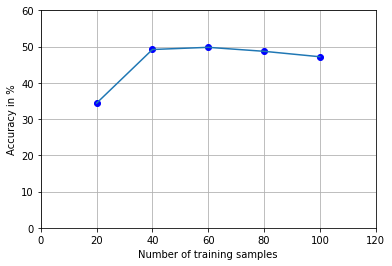

In [20]:
import numpy as np
binSize = np.array([20,40,60,80,100])
accuracy = np.array([34.4,49.2,49.8,48.7,47.2])
plt.plot(binSize,accuracy,'bo')
plt.plot(binSize,accuracy)
#-- add a annotations
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy in %')
plt.axis([0,120,0,60])
plt.grid(True)